In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [14]:
# 1. Load and Preprocess Data
# We read the dataset and ensure the timestamp is in the correct format for feature extraction.
df = pd.read_csv('BORIVALI_DWLR_REALTIME_multi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [15]:
def create_features(df):
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    return df

df = create_features(df)

In [16]:
df_encoded = pd.get_dummies(df, columns=['status'], prefix='status', dtype=int)
status_cols = [col for col in df_encoded.columns if col.startswith('status_')]

# Define our feature set and the targets we want to predict.
numerical_targets = ['water_level_m', 'rainfall_mm', 'temperature_c', 'demand_mcm', 'availability']
all_targets = numerical_targets + status_cols
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

In [17]:
models = {}
metrics_summary = []

X = df_encoded[features]

print("--- Training Gradient Boosting Models and Calculating NRMSE ---")
for target in all_targets:
    y = df_encoded[target]
    
    # Calculate the range for normalization (Max - Min).
    # If the range is 0 (constant value), we set it to 1 to avoid division by zero.
    target_range = y.max() - y.min()
    if target_range == 0: target_range = 1
    
    # Split the historical data into 80% training and 20% testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the Gradient Boosting model.
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    models[target] = model
    
    # Evaluate performance on the test set.
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # NRMSE is RMSE divided by the range, expressing error as a percentage of the scale.
    nrmse = rmse / target_range
    
    metrics_summary.append({
        'Target': target,
        'RMSE': rmse,
        'NRMSE': nrmse
    })
    print(f"Target: {target:20} | NRMSE: {nrmse:.4f}")

--- Training Gradient Boosting Models and Calculating NRMSE ---
Target: water_level_m        | NRMSE: 0.0326
Target: rainfall_mm          | NRMSE: 0.1085
Target: temperature_c        | NRMSE: 0.0376
Target: demand_mcm           | NRMSE: 0.0952
Target: availability         | NRMSE: 0.0283
Target: status_Critical      | NRMSE: 0.1027
Target: status_Safe          | NRMSE: 0.1221
Target: status_Semi-Critical | NRMSE: 0.1679


In [18]:
last_timestamp = df['timestamp'].max()
future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=24, freq='h')
future_df = pd.DataFrame({'timestamp': future_dates})
future_df = create_features(future_df)

for target in all_targets:
    future_df[target] = models[target].predict(future_df[features])

# 6. Reverting One-Hot Predictions back to Classification Labels
# The model outputs a value between 0 and 1 for each status column. 
# We pick the column with the highest value as the "predicted" class.
future_df['predicted_status'] = future_df[status_cols].idxmax(axis=1)
future_df['predicted_status'] = future_df['predicted_status'].str.replace('status_', '')

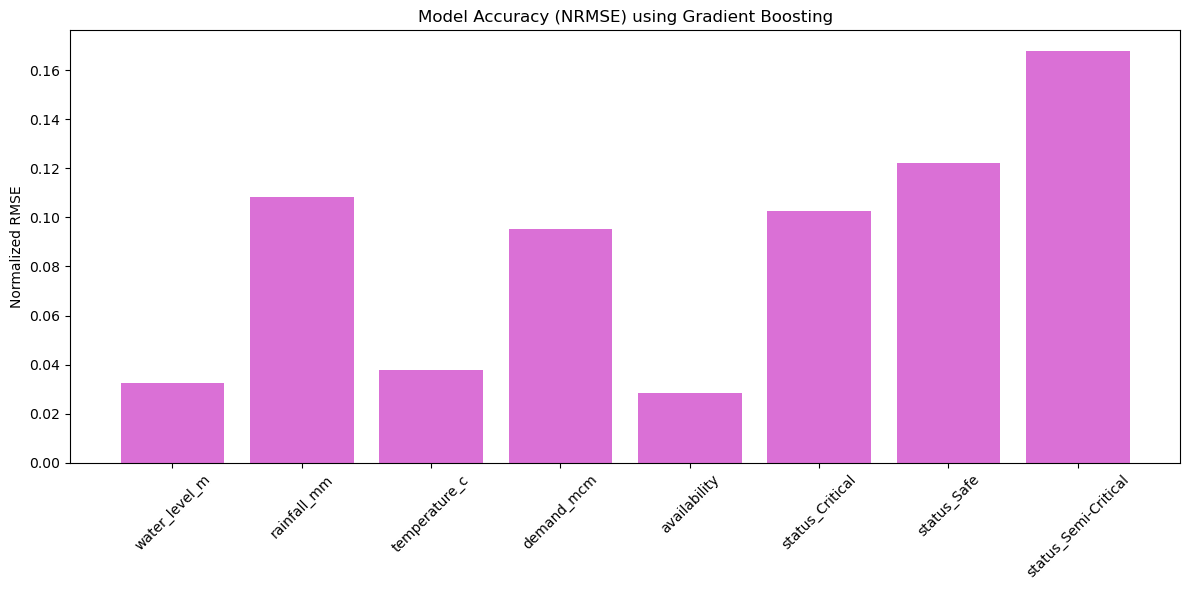

In [19]:
metrics_df = pd.DataFrame(metrics_summary)

plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Target'], metrics_df['NRMSE'], color='orchid')
plt.xticks(rotation=45)
plt.ylabel('Normalized RMSE')
plt.title('Model Accuracy (NRMSE) using Gradient Boosting')
plt.tight_layout()
plt.show()

In [ ]:
future_df.to_csv("24hrs_gb.csv")